<a href="https://colab.research.google.com/github/fatemafaria142/Loan-Approval-Prediction-using-Machine-Learning-Algorithms/blob/main/Loan_Approval_Prediction_using_XGBClassifier_with_NearMiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pip 21.3+ is required
!pip install xgboost

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler

In [4]:
file_path = "/content/drive/MyDrive/Practice_Project_Datasets/Applicant-details.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
# Display the first few rows of the DataFrame
print("First few rows:")
df.head()

First few rows:


,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,House_Ownership,Vehicle_Ownership(car),Occupation,Residence_City,Residence_State,Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk
0,75722,9657655,76,0,single,rented,no,Psychologist,Jalandhar,Punjab,0,12,0
1,80185,9259353,37,18,single,rented,no,Petroleum_Engineer,Bally,West_Bengal,12,11,0
2,19865,1509721,66,8,single,rented,no,Drafter,Indore,Madhya_Pradesh,4,12,0
3,76700,5867312,43,1,single,owned,no,Chartered_Accountant,Kurnool[18],Andhra_Pradesh,1,13,1
4,92992,7223191,44,9,single,rented,no,Air_traffic_controller,Asansol,West_Bengal,9,13,0


In [6]:
# Assuming df is our DataFrame
df['Residence_City'] = df['Residence_City'].str.replace(r'', '', regex=True)
df['Residence_State'] = df['Residence_State'].str.replace(r'', '', regex=True)

In [7]:
# Display the last few rows of the DataFrame
print("\nLast few rows:")
df.tail()


Last few rows:


,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,House_Ownership,Vehicle_Ownership(car),Occupation,Residence_City,Residence_State,Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk
99995,6266,156398,69,10,single,rented,yes,Technology_specialist,Bathinda,Punjab,7,14,0
99996,54887,1900932,69,11,single,rented,no,Mechanical_engineer,Erode[17],Tamil_Nadu,5,10,0
99997,76821,6395936,66,11,single,owned,no,Comedian,Gandhinagar,Gujarat,11,14,0
99998,861,4505937,52,6,single,rented,no,Petroleum_Engineer,Mangalore,Karnataka,6,14,0
99999,15796,4186842,58,9,single,rented,yes,Librarian,Raebareli,Uttar_Pradesh,5,13,0


In [8]:
# Step 1: Label Encoding for Categorical columns
label_encoder = LabelEncoder()
df['Marital_Status'] = label_encoder.fit_transform(df['Marital_Status'])
df['House_Ownership'] = label_encoder.fit_transform(df['House_Ownership'])
df['Vehicle_Ownership(car)'] = label_encoder.fit_transform(df['Vehicle_Ownership(car)'])
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])
df['Residence_City'] = label_encoder.fit_transform(df['Residence_City'])
df['Residence_State'] = label_encoder.fit_transform(df['Residence_State'])

In [9]:
# Display the first few rows of the DataFrame
print("After Label Encoding:")
df.head()

After Label Encoding:


,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,House_Ownership,Vehicle_Ownership(car),Occupation,Residence_City,Residence_State,Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk
0,75722,9657655,76,0,1,2,0,40,129,19,0,12,0
1,80185,9259353,37,18,1,2,0,36,29,28,12,11,0
2,19865,1509721,66,8,1,2,0,19,126,13,4,12,0
3,76700,5867312,43,1,1,1,0,7,170,0,1,13,1
4,92992,7223191,44,9,1,2,0,0,23,28,9,13,0


In [11]:
# Step 2: MinMax Scaling for numerical columns
scaler = MinMaxScaler()
numerical_columns = ['Annual_Income',	'Applicant_Age',	'Work_Experience',	'Marital_Status',	'House_Ownership',	'Vehicle_Ownership(car)',	'Occupation',	'Residence_City',	'Residence_State', 'Years_in_Current_Employment','Years_in_Current_Residence']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [12]:
# Step 3: Drop 'label' column
X = df.drop(['Applicant_ID','Loan_Default_Risk'], axis=1)
y = df['Loan_Default_Risk']

### **NearMiss:**

* NearMiss is an undersampling technique used to address imbalanced datasets in machine learning. Its goal is to reduce the number of majority class instances, particularly those that are considered "noise" or outliers, while retaining instances that are closer to the minority class. This is achieved by focusing on the examples that are near the decision boundary between the majority and minority classes.

In [40]:
# Step 4: Train-Test Split (80% train, 20% test) with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply NearMiss to undersample the majority class in the training set
# First, use RandomUnderSampler to achieve random undersampling with a specified random state
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Then, apply NearMiss to further refine the selection based on proximity to the minority class
nm = NearMiss(version=2)
X_train_resampled, y_train_resampled = nm.fit_resample(X_train_resampled, y_train_resampled)

In [41]:
# Create XGBoost model for binary classification
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model on the resampled training set
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
# Predictions on the test set
y_pred = model.predict(X_test)

In [43]:
# Binary classification evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, model.predict_proba(X_test)[:, 1])  # Use predict_proba for log loss in binary classification
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {logloss:.4f}")

Accuracy: 0.8995
Precision: 0.5658
Recall: 0.9750
F1 Score: 0.7160
Log Loss: 0.3103


In [44]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[15456  1945]
 [   65  2534]]


<ipython-input-45-31fb4172b4dc>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Metric', y='Value', data=metrics_df, palette=custom_colors, dodge=False)


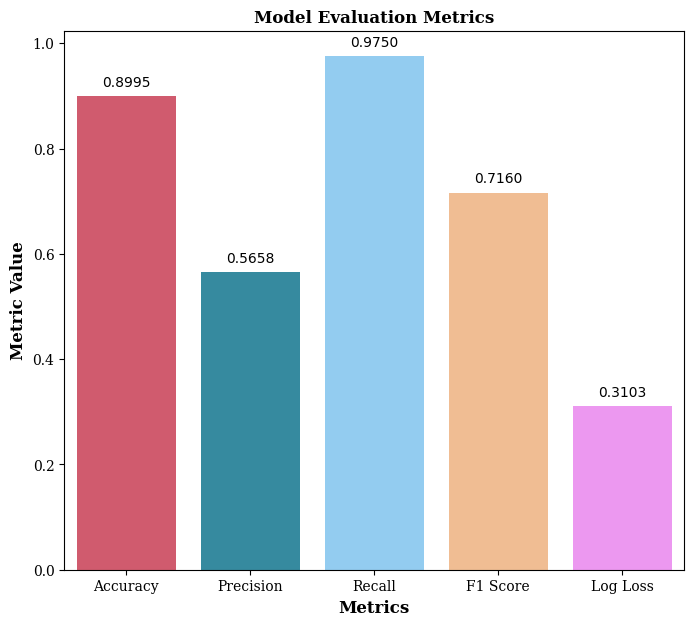

In [45]:
# Create a dictionary with metric names and values
metrics_dict = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1,'Log Loss':logloss}

# Convert the dictionary to a DataFrame for easy plotting
metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])

# Define custom colors for the bars
custom_colors = ['#e34861', '#2595b0', '#84d0ff', '#ffbb84','#f989ff']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.rcParams["figure.figsize"] = (8, 7)

# Use the hue parameter instead of palette
bar_plot = sns.barplot(x='Metric', y='Value', data=metrics_df, palette=custom_colors, dodge=False)

# Set title and axis labels using custom fontdict
plt.xlabel('Metrics',fontdict=font)
plt.ylabel('Metric Value',fontdict=font)
plt.title('Model Evaluation Metrics',fontdict=font)

# Annotate the bars with their values
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.4f}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

# Set custom font for ticks on both x and y axes with rotation
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)

# Show the plot
plt.show()


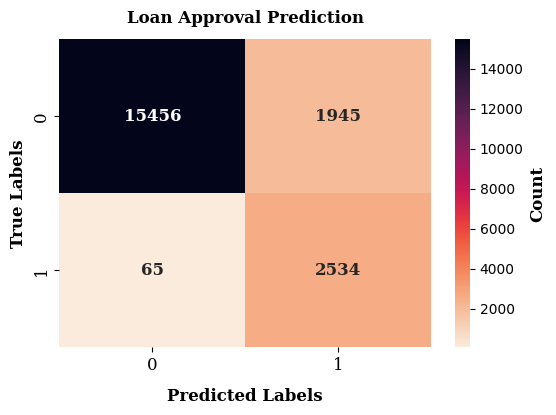

In [46]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette("rocket_r", as_cmap=True)# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=[0,1],
                      yticklabels=[0,1],
                      annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Loan Approval Prediction', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.show()